In [72]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from tqdm import tqdm

In [73]:
def sample_batch(batch_size, device='cpu'):
    data, _ = make_swiss_roll(batch_size)
    data = data[:, [2, 0]] / 10
    data = data * np.array([1, -1]) # Hacer un flip horizontal
    
    return torch.from_numpy(data).to(device)

In [74]:
class MLP(nn.Module):
    
    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super(MLP, self).__init__()
        
        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(hidden_dim, hidden_dim),
                                          nn.ReLU(),)
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                                            nn.ReLU(),
                                                            nn.Linear(hidden_dim, data_dim*2),) for t in range(N)])
        
    def forward(self, x, t):
        
        h = self.network_head(x)
        tmp = self.network_tail[t](h)  #[batch_size, data_dim * 2]
        
        mu, h = torch.chunk(tmp, 2, dim=1)
        var = torch.exp(h)
        std = torch.sqrt(var)
        
        return mu, std

In [75]:
model = MLP()
t = 5
x = torch.randn((64, 2))
mu, std = model(x, t)

print(mu.shape)
print(std.shape)

torch.Size([64, 2])
torch.Size([64, 2])


In [76]:
class DiffusionModel():
    def __init__(self, T, model: nn.Module, dim=2):
        
        self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, dim=0)
        
        self.T = T
        self.model = model
        self.dim = dim
        
    def forward_process(self, x0, t):
        """
        :param t: Number of diffusion steps
        """
        assert t > 0, 't shoudl be greater than 0'
        assert self.T <= self.T, 't should be lower or equal than {self.T}'
        
        t = t - 1 # Because we start indexing at 0
        
        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std = torch.sqrt(1 - self.alphas_bar[t])
        epsilon = torch.randn_like(x0)
        xt =  mu + std * epsilon # data ~ N(mu, std)
        
        std_q = torch.sqrt(((1 - self.alphas_bar[t-1])/(1 - self.alphas_bar[t])) * self.betas[t])
        m1 = torch.sqrt(self.alphas_bar[t-1]) * self.betas[t] / (1 - self.alphas_bar[t])
        m2 = torch.sqrt(self.alphas[t]) * (1 - self.alphas_bar[t-1]) / (1 - self.alphas_bar[t])
        mu_q = m1 * x0 + m2 * xt
        
        return mu_q, std_q, xt      
        
    def reverse_process(self, xt, t):
        """
        :param t: Number of diffusion steps
        """
        assert t > 0, 't shoudl be greater than 0'
        assert self.T <= self.T, 't should be lower or equal than {self.T}'
        
        t = t - 1 # Because we start indexing at 0
        
        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(xt)
        
        return mu, std, mu + std * epsilon # data ~ N(mu, std)
    
    def sample(self, batch_size):
        
        noise = torch.randn((batch_size, self.dim))
        x = noise
        
        samples = []
        for t in range(self.T, 0, -1):
            if not (t == 1):
                _, _, x = self.reverse_process(x, t)
            samples.append(x)
            
        return samples[::-1]
    
    def get_loss(self, x0):
        """
        :param x=: batch [batch_size, self.dim]
        """
        
        t = torch.randint(2, 40+1, (1,))
        mu_q, sigma_q, xt = self.forward_process(x0, t)
        mu_p, sigma_p, xt_minus1 = self.reverse_process(xt.float(), t)
        
        
        KL = torch.log(sigma_p) - torch.log(sigma_q) + \
                (sigma_q**2 + (mu_q - mu_p)**2) / (2*sigma_p**2)
        K = - (KL).mean() # Should be maximized
        loss = - K # Should be minimized
        
        return loss

In [77]:
x0 = sample_batch(5000)
mlp_model = torch.load('MODELS\PRETRAINED\model_paper1')
model = DiffusionModel(40, mlp_model)
xT = model.forward_process(x0, 20)

C:\Users\ander\AppData\Local\Temp\ipykernel_20104\1885290973.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model = torch.load('MODELS\PRETRAINED\model_paper1')


In [78]:
def plot(model, filename):
    fontsize = 14
    fig = plt.figure(figsize=(10, 6))

    N = 5000
    x0 = sample_batch(N)
    samples = model.sample(N)

    data = [x0, model.forward_process(x0, 20)[-1], model.forward_process(x0, 40)[-1]]
    for i in range(3):
        plt.subplot(2, 3, 1+i)
        plt.scatter(data[i][:, 0].data.numpy(), data[i][:, 1].data.numpy(), alpha=0.1)
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        
        if i == 0: plt.ylabel(r'$q(\mathbf{x}^{(0..T)})$', fontsize=fontsize)
        if i == 0: plt.title('t = 0', fontsize=fontsize)
        if i == 1: plt.title(r'$t=\frac{T}{2}$', fontsize=fontsize)
        if i == 2: plt.title('t = T', fontsize=fontsize)
    
    time_steps = [0, 20, 39] 
    for i in range(3):
        plt.subplot(2, 3, 4+i)
        plt.scatter(samples[time_steps[i]][:, 0].data.numpy(), samples[time_steps[i]][:, 1].data.numpy(), alpha=0.1, c='r')
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        
        if i == 0: plt.ylabel(r'$p(\mathbf{x}^{(0..T)})$', fontsize=fontsize)

    plt.savefig(f'IMGS/TRAINING/{filename}.png', bbox_inches='tight')
    plt.close()


In [ ]:
x0 = sample_batch(128)
model.get_loss(x0)

def train(diffusion_model, optimizer, batch_size, np_epochs):
    
    training_loss = []
    for epoch in tqdm(range(np_epochs)):
        x0 = sample_batch(batch_size)
        loss = diffusion_model.get_loss(x0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss.append(loss.item())
        
        if epoch % 2500 == 0:
            plt.plot(training_loss)
            plt.savefig('training_loss.png', bbox_inches='tight')
            plt.show()
            
            plot(diffusion_model, f'training_epoch_{epoch}')
        
    return training_loss

  0%|          | 0/300000 [00:00<?, ?it/s]

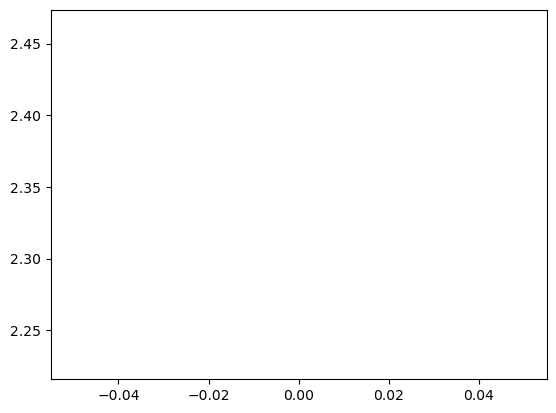

  0%|          | 499/300000 [00:33<5:27:45, 15.23it/s]

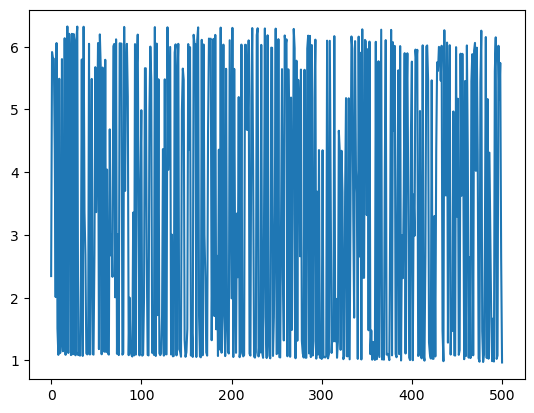

  0%|          | 999/300000 [01:07<5:30:33, 15.08it/s] 

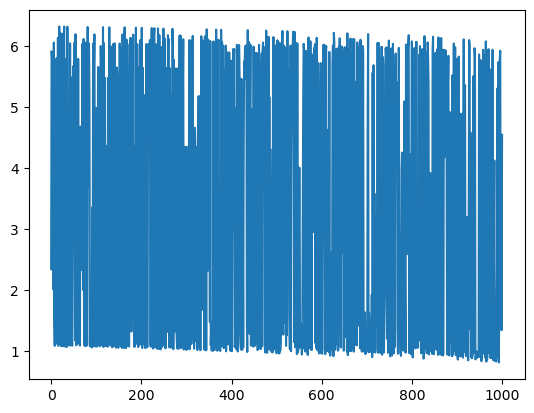

  0%|          | 1499/300000 [01:41<5:34:35, 14.87it/s] 

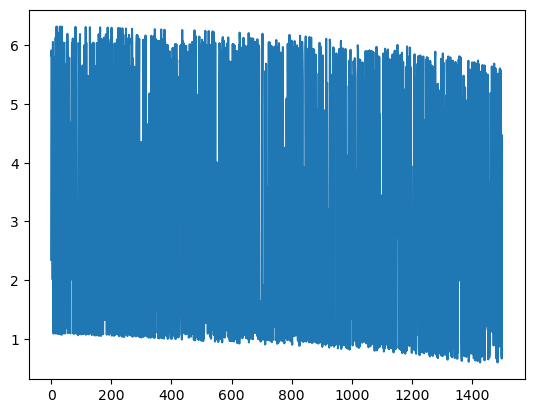

  1%|          | 1744/300000 [01:59<5:40:15, 14.61it/s] 


KeyboardInterrupt: 

In [80]:

mlp_model = MLP(hidden_dim=128)
model = DiffusionModel(40, mlp_model)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-4)

train(model, optimizer, 64000, 300000)